# Text classification with Reuters-21578 datasets

### See: https://kdd.ics.uci.edu/databases/reuters21578/README.txt for more information

In [0]:
%pylab inline

In [0]:
!pip install gensim

In [0]:
import re
import xml.sax.saxutils as saxutils

from numpy import *
import numpy as np

from bs4 import BeautifulSoup

from gensim.models.word2vec import Word2Vec

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM

from multiprocessing import cpu_count

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, sent_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.lancaster import *
from nltk.stem.wordnet import *

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn import model_selection

from pandas import DataFrame
import pandas as pd

from sklearn.cross_validation import train_test_split
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

In [0]:
import nltk

In [0]:
nltk.download('punkt')
nltk.download('stopwords')

## General constants (modify them according to you environment)

In [0]:
!mkdir ./data

In [0]:
!wget https://github.com/kirill-gerasimov/ds/raw/feature/reuters-w2v-lstm/nb/9_word2vec_and_nn/data/reutersCSV.csv

In [0]:
!mv *.csv ./data/

In [0]:
!ls

In [0]:
!ls ./data

In [0]:
# Set Numpy random seed
random.seed(1000)

# Newsline folder and format
data_folder = './data'

# Limit each newsline to a fixed number of words
document_max_num_words = 200 # 500 # 1000
# Selected categories
# selected_categories = ['pl_usa']

csv_df = pd.read_csv(data_folder + '/reutersCSV.csv', encoding='iso-8859-1', keep_default_na=False)

## Prepare documents and categories

In [8]:
# Create category dataframe
all_topics = [ re.sub('topic\.', '', col) for col in csv_df.columns if col.startswith('topic.') ]
print('\n', 'num topics:', len(all_topics))
pd.DataFrame(all_topics, columns=['topic name']).head(15)

# Create category dataframe
news_categories = DataFrame(data={'Name':all_topics, 'Type': 'Topics', 'Newslines':np.zeros(len(all_topics))})


 num topics: 135


In [9]:
news_categories.head()

,Name,Newslines,Type
0,acq,0.0,Topics
1,alum,0.0,Topics
2,austdlr,0.0,Topics
3,austral,0.0,Topics
4,barley,0.0,Topics


In [0]:
def update_frequencies(categories):
    for category in categories:
        idx = news_categories[news_categories.Name == category].index[0]
        f = news_categories.get_value(idx, 'Newslines')
        news_categories.set_value(idx, 'Newslines', f+1)
    
def to_category_vector(categories, target_categories):
    vector = zeros(len(target_categories)).astype(float32)
    
    for i in range(len(target_categories)):
        if target_categories[i] in categories:
            vector[i] = 1.0
    
    return vector

## 5 Roughly Even categories (by number of newslines)

In [0]:
topics_binarized = np.array(csv_df.values[:,3:-3])

In [0]:
def topic_list_from_binarized(binarized):
    return [ topic for (has, topic) in zip(binarized, all_topics) if has == 1 ]

topic_lists = [ topic_list_from_binarized(binarized) for binarized in topics_binarized ]

In [13]:
df = csv_df[[ 'pid', 'purpose', 'doc.title', 'doc.text' ]]
df = df.assign(topic_list = topic_lists)
df = df.assign(topics_binarized = topics_binarized.tolist())
df = df.assign(num_topics = np.array([ len(lst) for lst in topic_lists ]))
df.head()

,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
0,1,train,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...,[cocoa],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",1
1,2,train,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,3,train,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,4,train,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...,[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,5,train,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...,"[barley, corn, grain, oat, sorghum, wheat]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6


In [0]:
roughly_even_topics = [
    'money.fx',
    'crude',
    'grain',
    'trade',
    'interest',
]
all_topics = roughly_even_topics
selected_categories = roughly_even_topics

In [15]:
roughly_even_topics_set = set(roughly_even_topics)
df = df[df.apply(
    lambda row: len(row['topic_list']) == 1 and set(row['topic_list']).issubset(roughly_even_topics_set),
    axis = 1
)]

binarizer = MultiLabelBinarizer(classes = roughly_even_topics)

topic_lists = df.apply(lambda row : row['topic_list'][0], axis = 1).values.reshape(len(df), 1)
roughly_even_topics_binarized = binarizer.fit_transform(topic_lists)
roughly_even_topics_binarized[:5]

array([[0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]])

## Tokenize newsline documents

In [16]:
df_train = df[df['purpose'] == 'train']
df_test = df[df['purpose'] == 'test']

n_classes = len(all_topics)

print('total docs', len(df))
print('num train examples', len(df_train))
print('num test examples', len(df_test))
df.head()


total docs 1414
num train examples 943
num test examples 377


,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
46,47,train,BRAZIL ANTI-INFLATION PLAN LIMPS TO ANNIVERSARY,"inflation plan, initially hailed at home and a...",[trade],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
123,124,train,U.S. GRAIN CARLOADINGS FALL IN WEEK,"U.S. grain carloadings totaled 26,108 cars in ...",[grain],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
126,127,train,DIAMOND SHAMROCK (DIA) CUTS CRUDE PRICES,Diamond Shamrock Corp said that effective toda...,[crude],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
135,136,train,GAO LIKELY TO SHOW CERTS MORE COSTLY THAN CASH,A study on grain certificates due out shortly ...,[grain],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
143,144,train,OPEC MAY HAVE TO MEET TO FIRM PRICES - ANALYSTS,OPEC may be forced to meet before a scheduled ...,[crude],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [0]:
def lower_case(string):
    return string.lower()

def fix_lt(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'&lt;', '<', string)

def remove_reuter(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'reuter$', '', string)

def replace_non_alphanumeric_with_space(string):
    # replace punctuation and different whitespace with space character
    return re.sub(r'[^a-z0-9 ]', ' ', string)

def strip_punctuation(string):
    # remove punctuation
    return re.sub(r'[^a-z0-9\s]', ' ', string)

def remove_stop_words(string, stop_words):
    return ' '.join([ word for word in re.split(' ', string) if not word in stop_words ])

def replace_numeric_with_literal(string):
    return re.sub(r'([0-9]+ ?)+', '<num> ', string)

def compact_whitespace(string):
    return re.sub(r'\s+', ' ', string)

def stem(string, stemmer):
    return ' '.join([ 
        stemmer.stem(word) if hasattr(stemmer, 'stem') else stemmer.lemmatize(word)
        for word in re.split(' ', string) if not word in stop_words 
    ])

In [0]:
stop_words = stopwords.words('english')

stemmer = LancasterStemmer()

In [0]:
def pre_process(string):
    s = lower_case(string)
    s = fix_lt(s)
    s = remove_reuter(s)
    s = strip_punctuation(s)
    s = remove_stop_words(s, stop_words)
    s = compact_whitespace(s)
    s = replace_numeric_with_literal(s)
    s = stem(s, stemmer)
    return s.strip()

In [0]:
def pre_process_df(df):
    return df.apply(lambda row : pre_process(row['doc.title'] + ' ' + row['doc.text']), axis = 1).values

In [0]:
pre_processed_train = pre_process_df(df_train)

In [0]:
pre_processed_test = pre_process_df(df_test)

In [0]:
def get_counts_by_word(docs):
    word_counts = {}
    for doc in docs:
        for word in doc.split():
            if len(word) > 0:
                if word not in word_counts:
                    word_counts[word] = 0
                word_counts[word] += 1
    return word_counts

counts_by_word = get_counts_by_word(
    df.apply(lambda row : row['doc.title'] + ' ' + row['doc.text'], axis = 1).values
)

In [0]:
counts_by_word_pre_processed_train = get_counts_by_word(pre_processed_train)

In [25]:
num_words = 3000
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False)[4:num_words].head(20)

,count
bank,1250
oil,1108
bil,1062
pct,1029
rat,964
reut,897
mln,857
market,833
would,814
year,756


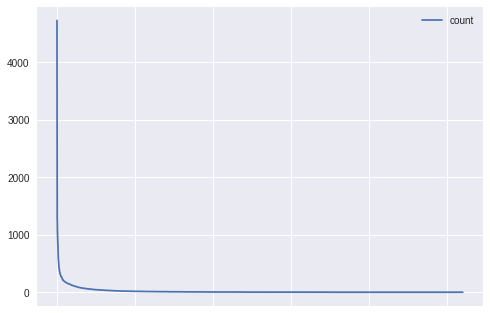

In [26]:
pd.DataFrame(pd.Series(counts_by_word_pre_processed_train, name='count')).sort_values('count', ascending=False).plot()

In [27]:
top_words = list(counts_by_word_pre_processed_train.items())
top_words.sort(key = lambda it: it[1])
top_words.reverse()
top_words = [ word for word, count in top_words[:num_words] ]
print(len(top_words))
top_words[:10]

3000


['<num>', 'said', 'trad', 'u', 'bank', 'oil', 'bil', 'pct', 'rat', 'reut']

In [0]:
def replace_rare_words_with_literal(string, top_words):
    return ' '.join([ (word if word in top_words else '') for word in re.split(' ', string) ])

pre_processed_train = [ 
    replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_train
]

pre_processed_test = [ 
    replace_rare_words_with_literal(doc, top_words) for doc in pre_processed_test
]

## Word2Vec Model
### See: https://radimrehurek.com/gensim/models/word2vec.html and https://code.google.com/p/word2vec/ for more information

In [0]:
# Load an existing Word2Vec model
# w2v_model = Word2Vec.load(data_folder + 'reuters.word2vec')

In [29]:
df.head()

,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
46,47,train,BRAZIL ANTI-INFLATION PLAN LIMPS TO ANNIVERSARY,"inflation plan, initially hailed at home and a...",[trade],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
123,124,train,U.S. GRAIN CARLOADINGS FALL IN WEEK,"U.S. grain carloadings totaled 26,108 cars in ...",[grain],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
126,127,train,DIAMOND SHAMROCK (DIA) CUTS CRUDE PRICES,Diamond Shamrock Corp said that effective toda...,[crude],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
135,136,train,GAO LIKELY TO SHOW CERTS MORE COSTLY THAN CASH,A study on grain certificates due out shortly ...,[grain],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
143,144,train,OPEC MAY HAVE TO MEET TO FIRM PRICES - ANALYSTS,OPEC may be forced to meet before a scheduled ...,[crude],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [30]:
len(df)

1414

In [31]:
len(csv_df)

21578

In [33]:
csv_df.head()

,pid,fileName,purpose,topic.acq,topic.alum,topic.austdlr,topic.austral,topic.barley,topic.bfr,topic.bop,...,topic.tung,topic.tung.oil,topic.veg.oil,topic.wheat,topic.wool,topic.wpi,topic.yen,topic.zinc,doc.title,doc.text
0,1,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BAHIA COCOA REVIEW,Showers continued throughout the week in the B...
1,2,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,STANDARD OIL &lt;SRD> TO FORM FINANCIAL UNIT,Standard Oil Co and BP North America Inc said ...
2,3,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TEXAS COMMERCE BANCSHARES &lt;TCB> FILES PLAN,Texas Commerce Bancshares Inc's Texas Commerce...
3,4,0,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,TALKING POINT/BANKAMERICA &lt;BAC> EQUITY OFFER,BankAmerica Corp is not under pressure to act ...
4,5,0,train,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,NATIONAL AVERAGE PRICES FOR FARMER-OWNED RESERVE,The U.S. Agriculture Department reported the f...


In [34]:
all_sentences = pre_process_df(csv_df)
print("type", type(all_sentences), "shape", all_sentences.shape)

type <class 'numpy.ndarray'> shape (21578,)


In [35]:
allwords = [] 
for s in all_sentences: 
    allwords.append(s.split())

print(len(allwords))

21578


In [0]:
!wget http://mattmahoney.net/dc/text8.zip

In [0]:
!mv *.zip ./data/

In [0]:
!ls ./data

In [0]:
!unzip ./data/text8.zip -d ./data/

In [0]:
!ls ./data

In [0]:
import gensim
text8sentences = gensim.models.word2vec.Text8Corpus('./data/text8')

In [0]:
# Word2Vec number of features
num_features = 500 # 200 # 300
num_w2v_epochs = 5 # 15

In [0]:
w2v_model = Word2Vec.load(data_folder + '/reuters.word2vec.text8_1_and_reut_5.dim_500')

In [0]:
w2v_model = gensim.models.word2vec.Word2Vec(
    text8sentences,
    size = num_features,
    iter = 1,
    workers=cpu_count()
)

In [0]:
# Create new Gensim Word2Vec model
w2v_model_1 = Word2Vec(
    allwords, 
    size=num_features, 
    min_count=1, 
    window=5 # 10, # 8, 
    iter = num_w2v_epochs,
    workers=cpu_count()
)
w2v_model.init_sims(replace=True)

In [0]:
# Create new Gensim Word2Vec model
w2v_model.train(
    allwords,
    epochs = num_w2v_epochs,
    total_examples = len(allwords)
)
w2v_model.init_sims()

In [0]:
w2v_model.save(data_folder + '/reuters.word2vec.text8_1_and_reut_5.dim_500')

In [0]:
# w2v_model["head"]

## Vectorize each document

In [0]:
num_categories = len(selected_categories)


empty_word = zeros(num_features).astype(float32)

def tokensToVec(documents):
    X = zeros(shape=(len(documents), document_max_num_words, num_features)).astype(float32)
    
    for idx, document in enumerate(documents):
        for jdx, word in enumerate(document.split()):
            if jdx == document_max_num_words:
                break
            else:
                if word in w2v_model:
                    X[idx, jdx, :] = w2v_model[word]
                else:
                    X[idx, jdx, :] = empty_word
    return X

## Split training and test sets

In [39]:
X_train = tokensToVec(pre_processed_train)
X_test = tokensToVec(pre_processed_test)

def to_category_vector(categories, target_categories):
    vector = zeros(len(target_categories)).astype(float32)
    
    for i in range(len(target_categories)):
        if target_categories[i] in categories:
            vector[i] = 1.0
    
    return vector

def single_label(dft):
    topics = dft.apply(lambda row : row['topic_list'][0], axis = 1).values
    
    result = []
    for i in topics:
        result.append(to_category_vector(i, roughly_even_topics))
    
    return np.array(result)


Y_train = single_label(df_train)
Y_test = single_label(df_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [40]:
Y_test[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

## Create Keras model

In [41]:
print("document_max_num_words=", document_max_num_words)
print("num_features=", num_features)

num_categories = len(roughly_even_topics)
print("num_categories ", num_categories)

df_test[4:9]

document_max_num_words= 200
num_features= 500
num_categories  5


,pid,purpose,doc.title,doc.text,topic_list,topics_binarized,num_topics
14911,14912,test,JAPAN GIVEN LITTLE HOPE OF AVOIDING U.S. SANCT...,A top U.S. Official said Japan has little chan...,[trade],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
14986,14987,test,STOLTENBERG SEES MOVES TO STRENGTHEN PARIS ACCORD,West German Finance Minister Gerhard Stoltenbe...,[money.fx],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
15047,15048,test,TOP OFFICIALS ARRIVE AT TREASURY FOR G-5 TALKS,Top officials of leading industrial nations ar...,[money.fx],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
15048,15049,test,FED EXPECTED TO SET CUSTOMER REPURCHASES,The Federal Reserve is expected to intervene i...,[interest],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
15091,15092,test,"FED SETS OVERNIGHT SYSTEM REPURCHASES, FED SAYS",,[interest],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


In [0]:
model = Sequential()

model.add(LSTM(
    int(document_max_num_words*1.5), 
    input_shape=(document_max_num_words, num_features)
))
model.add(Dropout(
    0.3
))
model.add(Dense(num_categories))
model.add(Activation(
    'sigmoid'
))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train and evaluate model

In [43]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(943, 200, 500) (943, 5) (377, 200, 500) (377, 5)


In [45]:
# Train model
history = model.fit(X_train, Y_train, batch_size=256, epochs=80, validation_data=(X_test, Y_test))

Train on 943 samples, validate on 377 samples
Epoch 1/80
943/943 [==============================] - 3s 4ms/step - loss: 1.5925 - acc: 0.2524 - val_loss: 1.5630 - val_acc: 0.2069
Epoch 2/80
943/943 [==============================] - 3s 3ms/step - loss: 1.5591 - acc: 0.2619 - val_loss: 1.5434 - val_acc: 0.3263
Epoch 3/80
943/943 [==============================] - 3s 3ms/step - loss: 1.5175 - acc: 0.2948 - val_loss: 1.4398 - val_acc: 0.3607
Epoch 4/80
943/943 [==============================] - 3s 3ms/step - loss: 1.4340 - acc: 0.3128 - val_loss: 1.4118 - val_acc: 0.3687
Epoch 5/80
943/943 [==============================] - 3s 3ms/step - loss: 1.3754 - acc: 0.3563 - val_loss: 1.1969 - val_acc: 0.5040
Epoch 6/80
943/943 [==============================] - 3s 3ms/step - loss: 1.1773 - acc: 0.4952 - val_loss: 1.0319 - val_acc: 0.4934
Epoch 7/80
943/943 [==============================] - 3s 3ms/step - loss: 1.1492 - acc: 0.4920 - val_loss: 1.0250 - val_acc: 0.4881
Epoch 8/80
943/943 [==========

In [46]:
# Evaluate model
score, acc = model.evaluate(X_test, Y_test, batch_size=256)
    
print('Score: %1.4f' % score)
print('Accuracy: %1.4f' % acc)

377/377 [==============================] - 0s 972us/step
Score: 0.2408
Accuracy: 0.9178


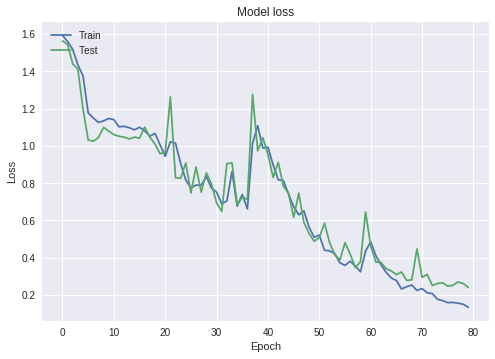

In [47]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
def binarize(t) :
    maxId = np.argmax(t, axis=1)
    binv = np.zeros((t.shape))
    for idx, pos in enumerate(maxId):
        binv[idx,pos] = 1

    return binv

In [49]:
y_test_predicted_labels = model.predict(X_test)

predicted = binarize(y_test_predicted_labels)

print("predicted shape ", y_test_predicted_labels.shape)
print("y_test    shape ", Y_test.shape)
print("predicted       ", y_test_predicted_labels)
print("predicted bin.  ", predicted)
print("Y test          ", Y_test)


accuracy_score(Y_test, predicted)
avg='weighted'
print('f1_score  :', f1_score(Y_test, predicted, average = avg))
#print('precision :', average_precision_score(y_test, predicted, average = avg))

predicted shape  (377, 5)
y_test    shape  (377, 5)
predicted        [[5.9068145e-04 2.5804431e-04 2.2069321e-03 7.8575021e-01 1.8628237e-03]
 [3.3050634e-03 7.6093688e-03 2.6377061e-01 3.6759224e-02 1.4609534e-03]
 [9.9498825e-04 3.3176411e-04 3.9088964e-03 8.1488258e-01 1.5014624e-03]
 ...
 [5.3052986e-01 1.1412645e-03 1.9347238e-04 5.5361650e-04 9.2922747e-03]
 [9.9094212e-04 3.3232121e-04 3.8790817e-03 8.1579131e-01 1.5085191e-03]
 [1.7168230e-03 8.1186908e-01 8.1755954e-04 2.6873947e-04 2.8108596e-04]]
predicted bin.   [[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]
Y test           [[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]]
f1_score  : 0.9167466329650332


In [0]:
t = array(
    [[0.2226171,  0.29442668, 0.05272774, 0.25584626, 0.22210537],
     [0.22258776, 0.219336527, 0.05255532, 0.35723976, 0.22122917]])
maxId = np.argmax(t, axis=1)
print(maxId)
print(t.shape)
binv = np.zeros((t.shape))
for idx, pos in enumerate(maxId):
    binv[idx,pos] = 1

print(binv)

## other

In [0]:
print(X_train)

In [0]:
print(Y_train)

In [0]:
print('X shape', X_train.shape)
print(X_train)

In [0]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

In [0]:
# Spot Check Algorithms
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

# LOG


```
max len   window    dim      df%     epochs     acc     f1
500       8         200      full    80         65%     ?
200       10        300      full    
```

